## Project: Spam Message Detection using Machine Learning

In [39]:
# Import liraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Set style
plt.style.use('seaborn-v0_8-whitegrid')

from sklearn.model_selection import train_test_split

In [40]:
# Read data
file_path = "../Data/raw/spam.csv"
data = pd.read_csv(file_path, encoding='latin-1')

# Drop na
data = data.dropna(how='any', axis=1)
data.columns = ['label', 'msg']

In [41]:
# view
data.head()

,label,msg
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [42]:
data.shape

(5572, 2)

In [43]:
# Check for duplicates
data.duplicated().sum()

403

In [44]:
# Drop duplicates
data.drop_duplicates(ignore_index=True, inplace=True)

In [45]:
# Check for missing values
data.isnull().sum()

label    0
msg      0
dtype: int64

In [46]:
# create a message length column
data['msg_length'] = data['msg'].apply(lambda msg: len(msg))

In [47]:
# view
data.head()

,label,msg,msg_length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [48]:
# Summary statistics
data['msg_length'].describe()

count    5169.000000
mean       78.977945
std        58.236293
min         2.000000
25%        36.000000
50%        60.000000
75%       117.000000
max       910.000000
Name: msg_length, dtype: float64

In [49]:
# Distribution of target variable class
data.label.value_counts(normalize=True) * 100

label
ham     87.366996
spam    12.633004
Name: proportion, dtype: float64

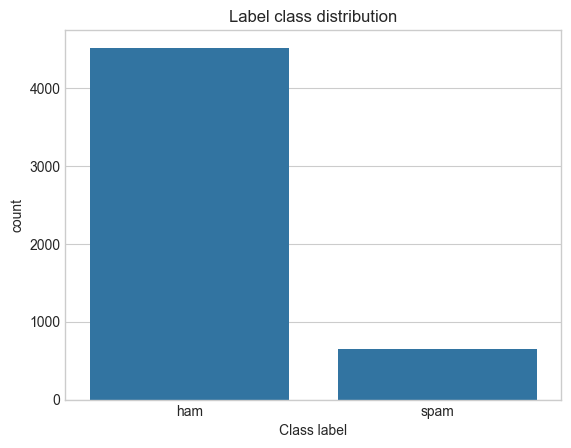

In [50]:
# Plot
sns.countplot(data, x='label')
plt.xlabel('Class label')
plt.title('Label class distribution')
plt.show()

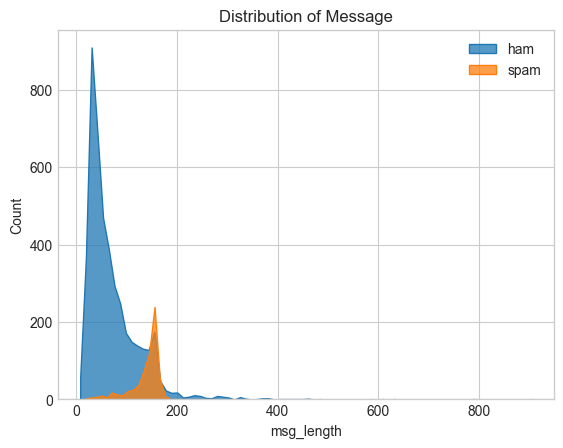

In [51]:
ham_df = data[data.label=='ham']['msg_length']
spam_df = data[data.label=='spam']['msg_length']

# plot the distribution
sns.histplot(ham_df, element='poly', bins=80, label='ham')
sns.histplot(spam_df, element='poly', bins=20, label='spam')

plt.title("Distribution of Message")
plt.legend();

In [52]:
# Summary statistics
spam_desc = data.loc[data.label == 1, 'msg_length'].describe()
ham_desc = data.loc[data.label == 0, 'msg_length'].describe()

pd.concat([ham_desc, spam_desc], keys = ['not_spam_desc', 'spam_desc'], axis=1)

,not_spam_desc,spam_desc
count,0.0,0.0
mean,NaN,NaN
std,NaN,NaN
min,NaN,NaN
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,NaN,NaN


There is substential difference between the length of the messages of the spam and ham category. The average length of not spam message is 70 where as for spam message it is 137.

### Data Cleaning

In [53]:
# Convert the categorical target variable into a numerical data
data['label'] = (data.label=='spam').astype('int')

In [54]:
data.head()

,label,msg,msg_length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [55]:
# Clean the corpus
import re
import string 

def clean_text(text):

    '''Make text lowercase,
    Remove text in sequare brackets, remove links, remove punctuation
    and remove words containing numbers.
    '''
    text = str(text).lower()
    text = re.sub('\[.*?]', '', text)
    text = re.sub('https?://\S+|WWW\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [56]:
data['msg_clean'] = data['msg'].apply(clean_text)

# view
data.head()

,label,msg,msg_length,msg_clean
0,0,"Go until jurong point, crazy.. Available only ...",111,go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,29,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry in a wkly comp to win fa cup final...
3,0,U dun say so early hor... U c already then say...,49,u dun say so early hor u c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,nah i dont think he goes to usf he lives aroun...


In [57]:
# Remove stopwords
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = stopwords.words('english')
stop_words.extend(['u', 'im', 'c'])

def remove_stopwords(text):
    text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    return text

data['msg_clean'] = data['msg_clean'].apply(remove_stopwords)

In [58]:
# view
data.head()

,label,msg,msg_length,msg_clean
0,0,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,29,ok lar joking wif oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry wkly comp win fa cup final tkts m...
3,0,U dun say so early hor... U c already then say...,49,dun say early hor already say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,nah dont think goes usf lives around though


In [59]:
# Stemming / Lematization
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

def stem_text(text):
    text = " ".join(stemmer.stem(word) for word in text.split(' '))
    return text

In [60]:
stemmer.stem('laughing')

'laugh'

In [61]:
# Apply above function to the message
data['msg_clean'] = data['msg_clean'].apply(stem_text)

In [62]:
# view
data.head()

,label,msg,msg_length,msg_clean
0,0,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,ok lar joke wif oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entri wkli comp win fa cup final tkts m...
3,0,U dun say so early hor... U c already then say...,49,dun say earli hor alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,nah dont think goe usf live around though


In [63]:
# Token visualization
from wordcloud import WordCloud, STOPWORDS

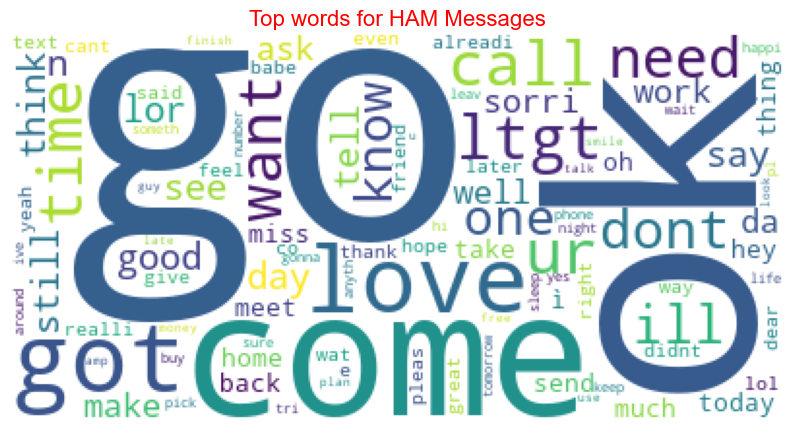

In [64]:
wc = WordCloud(background_color='white', 
               max_words = 100)

wc.generate(' '.join(text for text in data.loc[data.label == 0, 'msg_clean']))
plt.figure(figsize=(10, 15))
plt.title('Top words for HAM Messages', size=16, color='red')
plt.imshow(wc)
plt.axis('off')
plt.show()

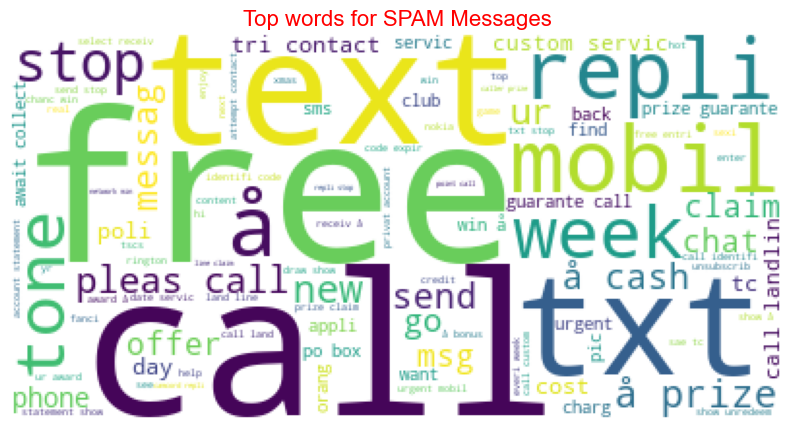

In [65]:
# Spam message common words
wc.generate(' '.join(text for text in data.loc[data.label == 1, 'msg_clean']))
plt.figure(figsize=(10, 15))
plt.title('Top words for SPAM Messages', size=16, color='red')
plt.imshow(wc)
plt.axis('off')
plt.show()

In [66]:
# Split the data into X, y
X = data['msg_clean'].copy()
y = data['label'].copy()

In [67]:
# Split into training, validation and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4135,) (1034,) (4135,) (1034,)


In [69]:
# Data transformation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


def transform_data(vector):

    # Initialize the given vector - CountVectorizer, TfidfVectorizer
    vectorizer = vector
    # Fit the vectorizer
    vectorizer.fit(X_train)

    # Vectorize the data
    X_train_cv = vectorizer.transform(X_train)
    X_test_cv = vectorizer.transform(X_test)

    # Transform data using TfidfTransformer
    tfidf_transformer = TfidfTransformer()

    # Fit the model on vectorized training data
    tfidf_transformer = tfidf_transformer.fit(X_train_cv)

    # Transform the data
    X_train_tr = tfidf_transformer.transform(X_train_cv)
    X_test_tr = tfidf_transformer.transform(X_test_cv)

    return vectorizer, tfidf_transformer, X_train_tr, X_test_tr

In [70]:
# CountVectorizer
vectorizer, tfidf_transformer, X_train_tr, X_test_tr = transform_data(CountVectorizer())

In [71]:
import warnings
warnings.filterwarnings('ignore')

# Import classifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier 
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from xgboost import XGBClassifier

# Import metrics for model evaluation
from sklearn.metrics import precision_score, accuracy_score
from sklearn.metrics import confusion_matrix

In [72]:
# Model building and evaluation
def get_score(y_true, y_pred):
    
    # compute accuracy
    precisionScore = precision_score(y_true, y_pred)
    accScore = accuracy_score(y_true, y_pred)

    return precisionScore, accScore

def eval_model(model):
    # fit the model on training data
    model.fit(X_train_tr, y_train)
    
    # Make predicitons
    y_preds = model.predict(X_test_tr)
    
    # Model evaluation
    class_report = confusion_matrix(y_test, y_preds)
    p_score, accuracy = get_score(y_test, y_preds)

    return p_score, accuracy, class_report, model

In [73]:
# Base model
nb_model = MultinomialNB()
nb_model.fit(X_train_tr, y_train)
precision, accuracy, class_report, nb_model = eval_model(nb_model)

print(f"Precision Score:: {precision:.3f}")
print(f"Precision Score:: {accuracy:.3f}")
print(class_report)

Precision Score:: 1.000
Precision Score:: 0.962
[[889   0]
 [ 39 106]]


In [74]:
# Model selection
models = {
    'LinearModel': LogisticRegression(),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'ExtraTrees' : ExtraTreesClassifier(random_state=42),
    'GradientBoost': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42), 
    'Bagging': BaggingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'Kneighbors': KNeighborsClassifier(),
    'SVC': SVC(),
    'GaussianNB': GaussianNB(),
    'BernoulliNB': BernoulliNB(),
    'MultinomialNB': MultinomialNB()

}

In [75]:
scores = []
for classifier, model in models.items():
    model = model.fit(X_train_tr.toarray(), y_train)
    y_preds = model.predict(X_test_tr.toarray())
    p_score, acc = get_score(y_test, y_preds)
    scores.append((classifier, p_score, acc))

In [76]:
# CountVectorizer scores
cv_scores = pd.DataFrame(scores, columns = ['Classifier', 'Precision', 'Accuracy'])
cv_scores.sort_values(by=['Precision', 'Accuracy'], ascending=False)

,Classifier,Precision,Accuracy
12,MultinomialNB,1.000000,0.962282
8,Kneighbors,1.000000,0.920696
3,ExtraTrees,0.991597,0.972921
2,RandomForest,0.991228,0.968085
11,BernoulliNB,0.991150,0.967118
9,SVC,0.983740,0.974855
0,LinearModel,0.946429,0.956480
4,GradientBoost,0.945455,0.954545
7,XGBoost,0.922481,0.965184
6,Bagging,0.890625,0.956480


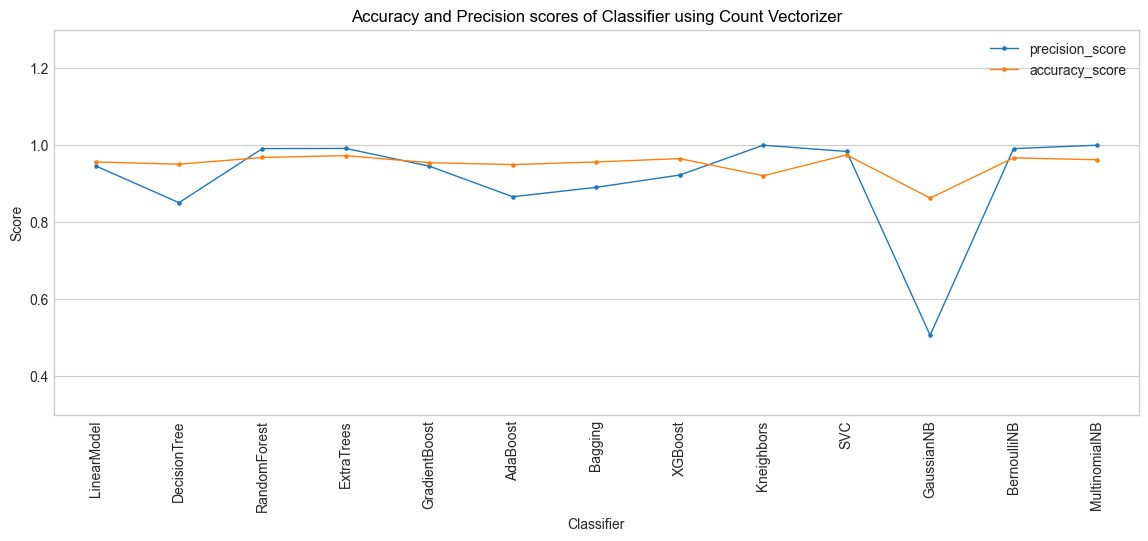

In [77]:
plt.figure(figsize=(14, 5))
sns.pointplot(cv_scores, x='Classifier', y='Precision', lw=1, label='precision_score')
sns.pointplot(cv_scores, x='Classifier', y='Accuracy', lw=1, label='accuracy_score')

plt.ylim(ymin=0.3, ymax=1.3)
plt.title('Accuracy and Precision scores of Classifier using Count Vectorizer', size=12, color='black')
plt.ylabel('Score')

plt.xticks(rotation='vertical')
plt.legend()
plt.show()

In [78]:
# TfidfVectorizer
tf_idfvectorizer, tfidf_transformer, X_train_tr, X_test_tr = transform_data(TfidfVectorizer())

In [79]:
scores = []
for classifier, model in models.items():
    model = model.fit(X_train_tr.toarray(), y_train)
    y_preds = model.predict(X_test_tr.toarray())
    p_score, acc = get_score(y_test, y_preds)
    scores.append((classifier, p_score, acc))

# CountVectorizer scores
tf_idf_scores = pd.DataFrame(scores, columns = ['Classifier', 'Precision', 'Accuracy'])
tf_idf_scores.sort_values(by=['Precision', 'Accuracy'], ascending=False)

,Classifier,Precision,Accuracy
12,MultinomialNB,1.000000,0.959381
8,Kneighbors,1.000000,0.915861
2,RandomForest,0.991304,0.969052
11,BernoulliNB,0.991150,0.967118
3,ExtraTrees,0.983607,0.973888
9,SVC,0.983193,0.970986
0,LinearModel,0.959596,0.947776
4,GradientBoost,0.954128,0.955513
6,Bagging,0.931034,0.956480
7,XGBoost,0.928571,0.964217


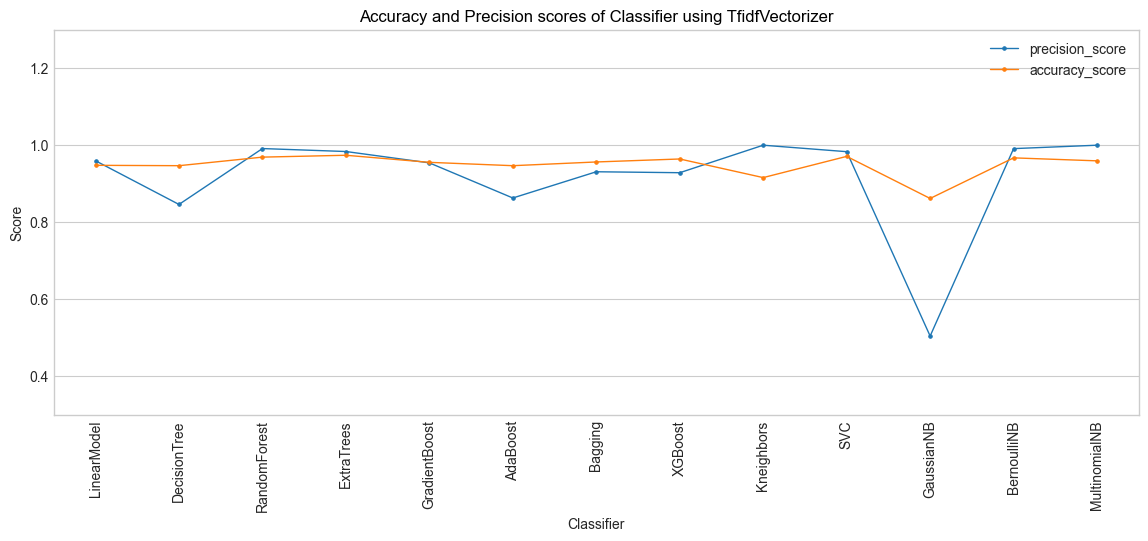

In [80]:
plt.figure(figsize=(14, 5))
sns.pointplot(tf_idf_scores, x='Classifier', y='Precision', lw=1, label='precision_score')
sns.pointplot(tf_idf_scores, x='Classifier', y='Accuracy', lw=1, label='accuracy_score')

plt.ylim(ymin=0.3, ymax=1.3)
plt.title('Accuracy and Precision scores of Classifier using TfidfVectorizer', size=12, color='black')
plt.ylabel('Score')

plt.xticks(rotation='vertical')
plt.legend()
plt.show()

In [81]:
X_train_tr.shape

(4135, 5933)

In [82]:
# TfidfVectorizer
tf_idfvectorizer, tfidf_transformer, X_train_tr, X_test_tr = transform_data(TfidfVectorizer(max_features=1000))

In [83]:
scores = []
for classifier, model in models.items():
    model = model.fit(X_train_tr.toarray(), y_train)
    y_preds = model.predict(X_test_tr.toarray())
    p_score, acc = get_score(y_test, y_preds)
    scores.append((classifier, p_score, acc))

In [84]:
# CountVectorizer scores
tf_idf_scores_mf_1k = pd.DataFrame(scores, columns = ['Classifier', 'Precision', 'Accuracy'])
tf_idf_scores_mf_1k.sort_values(by=['Precision', 'Accuracy'], ascending=False)

,Classifier,Precision,Accuracy
9,SVC,0.984127,0.977756
12,MultinomialNB,0.966667,0.968085
0,LinearModel,0.966102,0.966151
2,RandomForest,0.965812,0.965184
11,BernoulliNB,0.960938,0.973888
3,ExtraTrees,0.959350,0.969052
8,Kneighbors,0.950000,0.911992
4,GradientBoost,0.929825,0.954545
7,XGBoost,0.907692,0.962282
5,AdaBoost,0.870229,0.953578


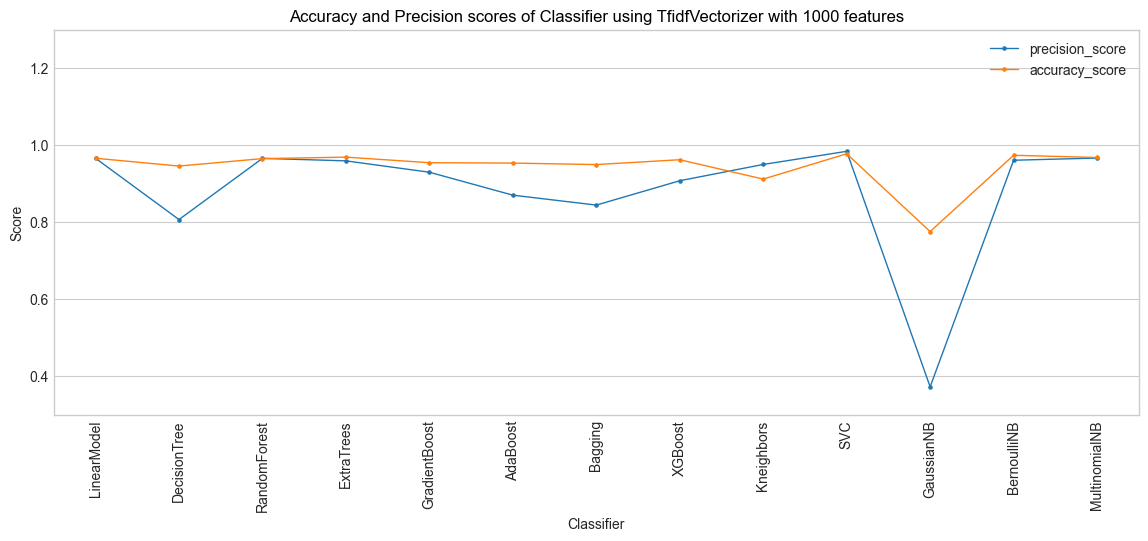

In [85]:
plt.figure(figsize=(14, 5))
sns.pointplot(tf_idf_scores_mf_1k, x='Classifier', y='Precision', lw=1, label='precision_score')
sns.pointplot(tf_idf_scores_mf_1k, x='Classifier', y='Accuracy', lw=1, label='accuracy_score')

plt.ylim(ymin=0.3, ymax=1.3)
plt.title('Accuracy and Precision scores of Classifier using TfidfVectorizer with 1000 features', size=12, color='black')
plt.ylabel('Score')

plt.xticks(rotation='vertical')
plt.legend()
plt.show()

In [86]:
# Combine the results
score_df = pd.concat([cv_scores, tf_idf_scores[['Precision', 'Accuracy']], tf_idf_scores_mf_1k[['Precision', 'Accuracy']]],
                keys = ['CountVectorizer', 'TfidfVectorizer', 'TfidfVectorizer_max_features_1K'],
                axis=1)
score_df.style.highlight_max(color='purple')

In [87]:
cv_scores.sort_values(by=['Precision', 'Accuracy'], ascending=False).head()

,Classifier,Precision,Accuracy
12,MultinomialNB,1.000000,0.962282
8,Kneighbors,1.000000,0.920696
3,ExtraTrees,0.991597,0.972921
2,RandomForest,0.991228,0.968085
11,BernoulliNB,0.991150,0.967118


In [88]:
tf_idf_scores.sort_values(by=['Precision', 'Accuracy'], ascending=False).head()

,Classifier,Precision,Accuracy
12,MultinomialNB,1.000000,0.959381
8,Kneighbors,1.000000,0.915861
2,RandomForest,0.991304,0.969052
11,BernoulliNB,0.991150,0.967118
3,ExtraTrees,0.983607,0.973888


In [89]:
tf_idf_scores_mf_1k.sort_values(by=['Precision', 'Accuracy'], ascending=False).head()

,Classifier,Precision,Accuracy
9,SVC,0.984127,0.977756
12,MultinomialNB,0.966667,0.968085
0,LinearModel,0.966102,0.966151
2,RandomForest,0.965812,0.965184
11,BernoulliNB,0.960938,0.973888


We will select the Multinomial naive bayes as it give highest precision for all vectorizer and increasing accuracy.

In [90]:
# Try: different number of features in tfidfvectorizer for naive bayes algorithm
scores = []
max_features = [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, X_train_tr.shape[1]]
for nfeatures in max_features:
    tf_idfvectorizer, tfidf_transformer, X_train_tr, X_test_tr = transform_data(TfidfVectorizer(max_features=nfeatures))
    
    # Intialized model
    mnb = MultinomialNB()

    # Fit the model on training data
    mnb.fit(X_train_tr.toarray(), y_train)
    y_preds = mnb.predict(X_test_tr.toarray()) # Make predictions
    # Get the score
    p_score, acc = get_score(y_test, y_preds)
    scores.append((nfeatures, p_score, acc))

In [91]:
pd.DataFrame(scores, columns=['MaxFeatures', 'Precision', 'Accuracy']).sort_values(by=['Precision', 'Accuracy'], ascending=False)

,MaxFeatures,Precision,Accuracy
3,2500,1.000000,0.970019
4,3000,1.000000,0.969052
5,3500,1.000000,0.967118
6,4000,1.000000,0.965184
7,4500,1.000000,0.964217
8,5000,1.000000,0.961315
2,2000,0.991597,0.972921
1,1500,0.975410,0.971954
0,1000,0.966667,0.968085
9,1000,0.966667,0.968085


2500 features gives highest precision and accuracy for Multinomial Naive Bayes. We will use this model to make prediction.

In [92]:
# create vectorizer and transformer with max_features equal to 2500.
tf_idfvectorizer, tfidf_transformer, X_train_tr, X_test_tr = transform_data(TfidfVectorizer(max_features=2500))

mnb_model = MultinomialNB()
mnb_model = mnb_model.fit(X_train_tr.toarray(), y_train)

In [93]:
# Save the model
import pickle

def save_model(file_name, obj):
    output_file = f"../Models/{file_name}"
    with open(output_file, 'wb') as f:
        pickle.dump(obj, f)

# Save the classifier
save_model("mnb_model.pkl", mnb_model)

# Vectorizer
save_model("tf_idfvectorizer.pkl", tf_idfvectorizer)

# Transformer
save_model("tfidf_transformer.pkl", tf_idfvectorizer)

In [94]:
# Step to get the output
# input_text --> clean_text --> remove_stopwords --> stem_text --> vectorize text --> transform text --> predict --> display output